# Interacting with dtap

## Accessing using the hdfs command

In [1]:
# jupyter
!hdfs dfs -ls dtap://TenantStorage/

Found 4 items
-rwxrwxrwx   3 cenz domain users       8828 2021-06-15 06:26 dtap://TenantStorage/.enhanced_sur_covid_19_eng.csv.crc
-rwxrwxrwx   3 cenz domain users         12 2021-06-15 06:21 dtap://TenantStorage/.hello.txt.crc
-rwxrwxrwx   3 cenz domain users    1128906 2021-06-15 06:26 dtap://TenantStorage/enhanced_sur_covid_19_eng.csv
-rwxrwxrwx   3 cenz domain users         11 2021-06-15 06:21 dtap://TenantStorage/hello.txt


## Into the pyspark

In [2]:
# python
from pyspark import SparkConf, SparkContext

In [3]:
# Specify the path of the jars files
conf = SparkConf().set("spark.jars", "/opt/bdfs/bluedata-dtap.jar")
sc = SparkContext( conf=conf)

In [4]:
# Specify the Hadoop configurations.
sc._jsc.hadoopConfiguration().set('fs.dtap.impl', 'com.bluedata.hadoop.bdfs.Bdfs')
sc._jsc.hadoopConfiguration().set('fs.AbstractFileSystem.dtap.impl', 'com.bluedata.hadoop.bdfs.BdAbstractFS')

In [5]:
# Commands for reading DataTap file.
text = sc.textFile("dtap://TenantStorage/hello.txt")
text.take(5)

['Hello', 'World']

# Reading COVID19 HK dataset

In [6]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()

In [7]:
# Commands for reading DataTap file.
# text = sc.textFile("dtap://TenantStorage/hello.txt")
# text.take(5)

df = spark.read.csv('dtap://TenantStorage/enhanced_sur_covid_19_eng.csv', header=True, inferSchema=True)
df.take(3)

[Row(Case no.=1, Report date='23/01/2020', Date of onset='21/01/2020', Gender='M', Age=39, Name of hospital admitted=None, Hospitalised/Discharged/Deceased='Discharged', HK/Non-HK resident='Non-HK resident', Case classification*='Imported case', Confirmed/probable='Confirmed'),
 Row(Case no.=2, Report date='23/01/2020', Date of onset='18/01/2020', Gender='M', Age=56, Name of hospital admitted=None, Hospitalised/Discharged/Deceased='Discharged', HK/Non-HK resident='HK resident', Case classification*='Imported case', Confirmed/probable='Confirmed'),
 Row(Case no.=3, Report date='24/01/2020', Date of onset='20/01/2020', Gender='F', Age=62, Name of hospital admitted=None, Hospitalised/Discharged/Deceased='Discharged', HK/Non-HK resident='Non-HK resident', Case classification*='Imported case', Confirmed/probable='Confirmed')]

In [8]:
df.printSchema()
df.show(5) # show top 5 result
df.count() # return number of data

root
 |-- Case no.: integer (nullable = true)
 |-- Report date: string (nullable = true)
 |-- Date of onset: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Name of hospital admitted: string (nullable = true)
 |-- Hospitalised/Discharged/Deceased: string (nullable = true)
 |-- HK/Non-HK resident: string (nullable = true)
 |-- Case classification*: string (nullable = true)
 |-- Confirmed/probable: string (nullable = true)

+--------+-----------+-------------+------+---+-------------------------+--------------------------------+------------------+--------------------+------------------+
|Case no.|Report date|Date of onset|Gender|Age|Name of hospital admitted|Hospitalised/Discharged/Deceased|HK/Non-HK resident|Case classification*|Confirmed/probable|
+--------+-----------+-------------+------+---+-------------------------+--------------------------------+------------------+--------------------+------------------+
|       1| 23/01/202

11879

In [9]:
Male_Agedgt93_df = df.select(df["`Case no.`"], df["Gender"], df["Age"]).filter('Age > 93').filter('Gender = "M"')
Male_Agedgt93_df.show()
Male_Agedgt93_df.count()

+--------+------+---+
|Case no.|Gender|Age|
+--------+------+---+
|    1365|     M| 94|
|    1612|     M| 94|
|    3122|     M| 94|
|    3734|     M| 95|
|    4256|     M| 94|
|    8444|     M| 95|
|    9062|     M| 95|
|    9665|     M| 94|
|    9677|     M| 94|
+--------+------+---+



9

In [10]:
Case2000_df = df.filter("`Case no.` = 2000")
Case2000_df.show()

+--------+-----------+-------------+------+---+-------------------------+--------------------------------+------------------+--------------------+------------------+
|Case no.|Report date|Date of onset|Gender|Age|Name of hospital admitted|Hospitalised/Discharged/Deceased|HK/Non-HK resident|Case classification*|Confirmed/probable|
+--------+-----------+-------------+------+---+-------------------------+--------------------------------+------------------+--------------------+------------------+
|    2000| 21/07/2020|   17/07/2020|     M| 61|                     null|                      Discharged|       HK resident|          Local case|         Confirmed|
+--------+-----------+-------------+------+---+-------------------------+--------------------------------+------------------+--------------------+------------------+



In [17]:
df.groupBy("Gender").mean("Age").show()

+------+-----------------+
|Gender|         avg(Age)|
+------+-----------------+
|     F|44.45564516129032|
|     M|43.82320831132242|
+------+-----------------+



In [11]:
Case_Classification_df = df.select(df["Case classification*"]).distinct()
Case_Classification_df.show(truncate = False)

+-------------------------------------------------+
|Case classification*                             |
+-------------------------------------------------+
|Local case                                       |
|Epidemiologically linked with imported case      |
|Epidemiologically linked with possibly local case|
|Epidemiologically linked with local case         |
|Imported case                                    |
|Possibly local case                              |
+-------------------------------------------------+



In [12]:
from pyspark.sql.functions import round, asc

In [13]:
df_roundAge = df.select("*",(10*round(df["Age"]/10,0)).alias("RoundAge"))
df_roundAge.groupBy("RoundAge").count().sort(asc("RoundAge")).show()

+--------+-----+
|RoundAge|count|
+--------+-----+
|     0.0|  290|
|    10.0|  477|
|    20.0| 1205|
|    30.0| 2017|
|    40.0| 2153|
|    50.0| 1845|
|    60.0| 1946|
|    70.0| 1236|
|    80.0|  480|
|    90.0|  211|
|   100.0|   19|
+--------+-----+



# Visualizing the plot using Matplotlib

In [14]:
import matplotlib.pyplot as plt

In [15]:
pandas_age = df.select("Age").toPandas()

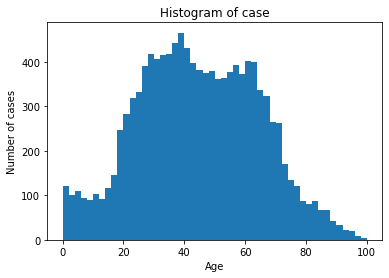

In [16]:
def pd_plt_histogram_df(inData_df_ary, num_bins, isDensity, text_xLabel, text_yLabel, text_title):
    # pd_plt_histogram_df(pandas_age["Age"], 50, False, 'Age', 'Number of cases', 'Histogram of case')

    # the histogram of the data
    n, bins, patches = plt.hist(inData_df_ary, num_bins, density=isDensity)

    plt.xlabel(text_xLabel)
    plt.ylabel(text_yLabel)
    plt.title(text_title)
    plt.show()
pd_plt_histogram_df(pandas_age["Age"], 50, False, 'Age', 'Number of cases', 'Histogram of case')